## Lab Assignment Seven: Sequential Network Architectures

Team: Katie Laird, Cameron Miller, Will Landin

Dataset: 

Select a dataset that is text. That is, the dataset should be text data. In terms of generalization performance, it is helpful to have a medium sized dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification should be "many-to-one" sequence classification.

Dataset: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/

In [1]:
import numpy as np
import pandas as pd
import re
import gc

### Preparation

[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence. 

In [2]:
# read in the dataset as a pandas dataframe
df = pd.read_csv("./Datasets/Corona_NLP.csv",encoding='latin1')
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


#### Clean the tweets text

In [3]:
def clean_tweet(tweet):
    # Remove any non-alphabetic characters except basic punctuation
    tweet = re.sub(r"[^a-zA-Z0-9.,'!? ]", '', tweet)
    # Remove any excess whitespace
    tweet = re.sub(r"\s+", ' ', tweet).strip()
    return tweet

In [4]:
df['OriginalTweet'] = df['OriginalTweet'].apply(clean_tweet)
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2/3/2020,TRENDING New Yorkers encounter empty supermark...,Extremely Negative
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2/3/2020,Panic buying hits NewYork City as anxious shop...,Negative
4,5,44957,"Melbourne, Victoria",3/3/2020,toiletpaper dunnypaper coronavirus coronavirus...,Neutral


In [5]:
print (df.value_counts('Sentiment'))
label_counts = df['Sentiment'].value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
dtype: int64


#### One Hot Encode Sentiments

In [6]:
# One Hot Encoding of the sentiments changing Extremely Negative and Negative to 0, Neutral to 1, and Positive and Extremely Positive to 2
df['Sentiment'] = df['Sentiment'].replace('Extremely Negative', 0)
df['Sentiment'] = df['Sentiment'].replace('Negative', 0)
df['Sentiment'] = df['Sentiment'].replace('Neutral', 1)
df['Sentiment'] = df['Sentiment'].replace('Positive', 2)
df['Sentiment'] = df['Sentiment'].replace('Extremely Positive', 2)
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2/3/2020,TRENDING New Yorkers encounter empty supermark...,0
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,2
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,2
3,4,44956,Chicagoland,2/3/2020,Panic buying hits NewYork City as anxious shop...,0
4,5,44957,"Melbourne, Victoria",3/3/2020,toiletpaper dunnypaper coronavirus coronavirus...,1


In [7]:
print(df['Sentiment'].value_counts())

2    19592
0    17031
1     8332
Name: Sentiment, dtype: int64


Undersample to balance the dataset

In [8]:
df_negative = df[df['Sentiment'] == 0]
df_neutral = df[df['Sentiment'] == 1]
df_positive = df[df['Sentiment'] == 2]

df_negative_sampled = df_negative.sample(n=min(8332, len(df_negative)), random_state=42)
df_neutral_sampled = df_neutral.sample(n=min(8332, len(df_neutral)), random_state=42)
df_positive_sampled = df_positive.sample(n=min(8332, len(df_positive)), random_state=42)

# Concatenate the sampled dataframes
df_undersampled = pd.concat([df_negative_sampled, df_neutral_sampled, df_positive_sampled])

# Optionally, shuffle the dataframe
df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

df = df_undersampled
df.value_counts('Sentiment')

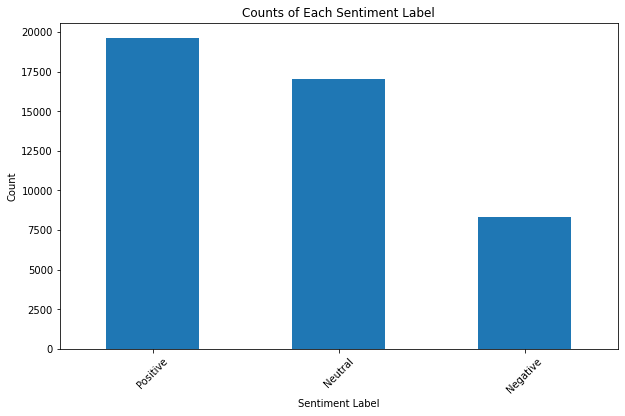

In [9]:
import matplotlib.pyplot as plt

label_counts = df['Sentiment'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Counts of Each Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Positive', 'Neutral', 'Negative'], rotation=45)
plt.show()

In [10]:
avg_length = np.mean([len(tweet) for tweet in df['OriginalTweet']])
max_length = np.max([len(tweet) for tweet in df['OriginalTweet']])
min_length = np.min([len(tweet) for tweet in df['OriginalTweet']])
print(f"Average length of tweets: {avg_length:.2f} Characters")
print(f"Max length of tweets: {max_length} Characters")
print(f"Min length of tweets: {min_length} Characters")

Average length of tweets: 195.10 Characters
Max length of tweets: 315 Characters
Min length of tweets: 3 Characters


In [11]:
#delete the negative, neutral, positive, and undersampled dataframes to help with memory
del df_negative, df_neutral, df_positive, df_negative_sampled, df_neutral_sampled, df_positive_sampled, df_undersampled

gc.collect()

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Our metrics are going to be accurac and precision

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

(35964,) (8991,) (35964,) (8991,)
X_train Shape: (35964,) Label Shape: (35964,)
X_test Shape: (8991,) Label Shape: (8991, 3)
Number of Classes: 3


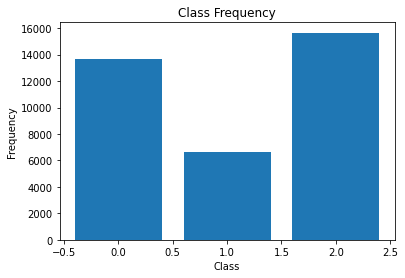

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_test = keras.utils.to_categorical(y_test, 3)

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train.shape)
print("X_test Shape:",X_test.shape, "Label Shape:", y_test.shape)
print("Number of Classes:", len(np.unique(y_train)))
plt.bar(np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1])
plt.title("Class Frequency")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [13]:
y_test[1]

array([0., 0., 1.], dtype=float32)

### Modeling

[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

#### Creating the embedding layer

In [14]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = np.max([len(tweet) for tweet in df['OriginalTweet']]) # maximum number of words in a tweet

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index
VOCAB_SIZE = len(tokenizer.word_index) + 1
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_ART_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_ART_LEN)


y_ohe = keras.utils.to_categorical(y_train, num_classes=3)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 79381 unique tokens. Distilled to 79381 top words.
Shape of data tensor: (35964, 315)
Shape of label tensor: (35964, 3)
79381
CPU times: total: 828 ms
Wall time: 4.18 s


In [15]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (79382, 100) 
 Total words found: 28284 
 Percentage: 35.63024363205764
CPU times: total: 4.38 s
Wall time: 16.7 s


In [16]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
    EMBED_SIZE,
    weights=[embedding_matrix], # here is the embedding getting saved
    input_length=MAX_ART_LEN,
    trainable=False)

#### Creating Sequential Convolutional Neural Network

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Subtract, Concatenate
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

def cnn_seq():
        EMBED_SIZE = 100  # same size as loaded from GLOVE
        sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
        embedded_sequences = embedding_layer(sequence_input) # from previous embedding
        
        x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(embedded_sequences)
        x = MaxPooling1D(5)(x)
        x = Dropout(0.2)(x)
        x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
        x = MaxPooling1D(5)(x)
        x = Dropout(0.2)(x)
        x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
        x = MaxPooling1D(5)(x)
        x = Flatten()(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
        preds = Dense(3, activation='softmax', kernel_initializer='glorot_uniform')(x)

        model = Model(sequence_input, preds)

        model.compile(loss='categorical_crossentropy', 
                optimizer='rmsprop',
                metrics=['acc'])
        return model
    
model = cnn_seq()
model.fit(X_train, y_ohe, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
225/225 [==============================] - 27s 110ms/step - loss: 1.0739 - acc: 0.4340 - val_loss: 1.0564 - val_acc: 0.4370
Epoch 2/10
225/225 [==============================] - 26s 116ms/step - loss: 1.0486 - acc: 0.4348 - val_loss: 1.0442 - val_acc: 0.4370
Epoch 3/10
225/225 [==============================] - 29s 129ms/step - loss: 1.0428 - acc: 0.4348 - val_loss: 1.0425 - val_acc: 0.4370
Epoch 4/10
225/225 [==============================] - 28s 125ms/step - loss: 1.0421 - acc: 0.4348 - val_loss: 1.0424 - val_acc: 0.4370
Epoch 5/10
225/225 [==============================] - 27s 122ms/step - loss: 1.0421 - acc: 0.4348 - val_loss: 1.0424 - val_acc: 0.4370
Epoch 6/10
225/225 [==============================] - 29s 129ms/step - loss: 1.0421 - acc: 0.4348 - val_loss: 1.0424 - val_acc: 0.4370
Epoch 7/10
225/225 [==============================] - 27s 120ms/step - loss: 1.0420 - acc: 0.4348 - val_loss: 1.0425 - val_acc: 0.4370
Epoch 8/10
225/225 [==============================] - 2

#### Creating Sequential Transformer

In [18]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
import tensorflow as tf


# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [19]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def seq_transformer(X_train, X_test, y_train, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = TokenAndPositionEmbedding(X_train.shape[1], VOCAB_SIZE, embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(3, activation='sigmoid',
                kernel_initializer='glorot_uniform')(x)


    xformer = Model(inputs=inputs, outputs=outputs)

    xformer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['acc'])

    history = xformer.fit(
        X_train, y_train, batch_size=64, epochs=5,
        validation_data=(X_test, y_test), verbose=0,
    )

    yhat = np.round(xformer.predict(X_test))

    return history, yhat

history, yhat = seq_transformer(X_train, X_test, y_ohe, y_test)

281/281 [==============================] - 7s 25ms/step


              precision    recall  f1-score   support

           0       0.85      0.80      0.82      3383
           1       0.71      0.79      0.75      1670
           2       0.87      0.82      0.84      3938

   micro avg       0.83      0.81      0.82      8991
   macro avg       0.81      0.80      0.81      8991
weighted avg       0.83      0.81      0.82      8991
 samples avg       0.81      0.81      0.81      8991



c:\Users\camer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


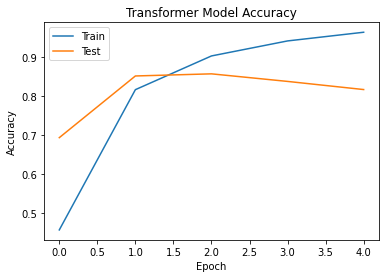

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat))

# print the accuracy and loss curves
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

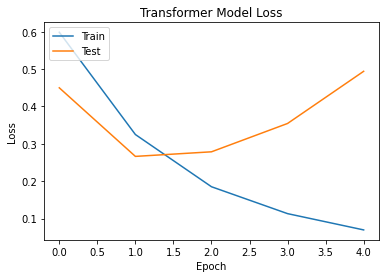

In [21]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations.

[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

### Exceptional Work

[1 points] Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application? 